In [3]:
import datetime as dt
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shutil
import sqlite3
import warnings

from pandas.core.common import SettingWithCopyWarning
from sklearn.decomposition import PCA
# from causalinference import CausalModel
from datetime import datetime
# from pandas.core.common import SettingWithCopyWarning
from pandas.tseries.offsets import MonthEnd
# from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [4]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
    
with open("cfg.json", "r") as jin:
    cfg = json.loads(jin.read())

    
# rewrite to ensure formatting
with open("cfg.json", "w") as jout:
    json.dump(cfg, jout, indent=4)

In [5]:
def installation_data_res(files):
    for i, file in enumerate(files):
        bk1 = pd.read_csv(file,encoding= 'unicode_escape', low_memory = False)
        if i == 0:
            bk = bk1.copy()
        else:
            bk = pd.concat([bk,bk1])
    
    bk = bk.replace({-9999:np.NaN}).replace({"-9999":np.NaN})


    
    bk_P = bk[(bk['customer_segment'] == 'RES') & (bk.zip_code != 'redacted')]
    bk_P = bk_P[cfg["filter_cols"]]

    bk_P['battery_rated_capacity_kWh'] = bk_P['battery_rated_capacity_kWh'].fillna(0)
    bk_P['installation_date'] = pd.to_datetime(bk_P['installation_date'])
    bk_P = bk_P.dropna(subset=['zip_code'])
    bk_P['zip_code'] = bk_P['zip_code'].apply(lambda a: str(a).split('-')[0].zfill(5))
    
    bk_P['install_month'] = bk_P.installation_date.dt.strftime('%Y-%m')
    bk_P['install_month'] = pd.to_datetime(bk_P['install_month']) + MonthEnd(1)
    
    bk_P_3 = bk_P[bk_P.system_size_DC <= 25]
    
    bk_P_rt = bk_P_3[(bk_P_3.ground_mounted != 1) & (bk_P_3.third_party_owned != 1) & (bk_P_3.zip_code != '00000')]
    bk_P_rt['cost_per_kW'] = bk_P_rt.total_installed_price/bk_P_rt.system_size_DC
    costs_df = bk_P_rt.groupby('install_month').cost_per_kW.mean().reset_index().dropna()
    
    min_yr = pd.to_datetime(bk_P_rt.installation_date.min()).year
    min_mo = pd.to_datetime(bk_P_rt.installation_date.min()).month
    min_date = bk_P_rt.installation_date.min().to_pydatetime().strftime("%d-%b-%Y (%H:%M:%S.%f)")
    max_date = bk_P_rt.installation_date.max().to_pydatetime().strftime("%d-%b-%Y (%H:%M:%S.%f)")
    
    cfg["min_date"] = min_date
    cfg["max_date"] = max_date
    
    with open("cfg.json", "w") as jout:
        json.dump(cfg, jout, indent=4)
    
    bk_P_rt['num_months'] = bk_P_rt.install_month.apply(
        lambda d: (d.year - min_yr) * 12 + (d.month - min_mo)
    )
    
    return bk_P_rt




In [6]:
files = [cfg["data_dir"] + cfg["berkeley_1"],
         cfg["data_dir"] + cfg["berkeley_2"]]

bk_P_rt = installation_data_res(files)

In [7]:
def find_anomalies(data):
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(data)
    random_data_mean = np.mean(data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    #print(lower_limit, upper_limit)
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies  

In [8]:
tf_df = bk_P_rt[['num_months','cost_per_kW']].dropna()
tf_df['PCA_cost'] = PCA(n_components = 1).fit_transform(tf_df[['num_months','cost_per_kW']])
outliers = find_anomalies(tf_df.PCA_cost)
ol_cost = tf_df[tf_df.PCA_cost.isin(outliers)].cost_per_kW
bk_P_rt = bk_P_rt[~bk_P_rt.cost_per_kW.isin(ol_cost)]

In [9]:
zip_list = sorted(bk_P_rt.zip_code.unique())
ct = len(zip_list)
zip_dict = dict(zip(zip_list, np.linspace(0,ct - 1, ct).astype(int)))

In [10]:
for i in zip_list:
    if len(i) > 5:
        zip_list.remove(i)

In [11]:
# conn_proj = sqlite3.connect("../data/Berkeley.db")
# cursor_proj = conn_proj.cursor()

# query_init = """
# DROP TABLE IF EXISTS zipcodes;
# """

# cursor_proj.execute(query_init)

# query = """
# CREATE TABLE zipcodes (
#    id INTEGER PRIMARY KEY AUTOINCREMENT,
#    zipcode text NOT NULL
#    );
# """

# cursor_proj.execute(query)

# for i, zipcode in enumerate(zip_list):
    
#     cursor_proj.execute("INSERT INTO zipcodes (zipcode) VALUES (?)", [zipcode])
#     conn_proj.commit()

# conn_proj.close

In [12]:
bk_P_rt = bk_P_rt[bk_P_rt.zip_code.apply(lambda x: len(x) == 5)]

bk_P_rt['zip_id'] = bk_P_rt.zip_code.map(zip_dict)

In [13]:
min_yr = pd.to_datetime(bk_P_rt.installation_date.min()).year
min_mo = pd.to_datetime(bk_P_rt.installation_date.min()).month

bk_P_rt['num_months'] = bk_P_rt.install_month.apply(
    lambda d: (d.year - min_yr) * 12 + (d.month - min_mo)
)

In [14]:
bk_P_rt['i_d'] = pd.to_datetime(bk_P_rt.installation_date).apply(lambda d: (d - datetime.strptime(cfg["min_date"], "%d-%b-%Y (%H:%M:%S.%f)")).days)


In [15]:
day_df = pd.DataFrame({'i_d':np.linspace(0,bk_P_rt.i_d.max(),bk_P_rt.i_d.max()+1).astype(int),'key':1})
zip_id_df = pd.DataFrame({'zip_id':bk_P_rt.zip_id.unique(),'key':1})
fill_df = pd.merge(day_df,zip_id_df, on = 'key').drop(columns = ['key'])


new_df = bk_P_rt.merge(fill_df, left_on = ['i_d','zip_id'], right_on = ['i_d','zip_id'], how = 'outer').sort_values(by = ['zip_id', 'i_d'])

z_dict = dict(zip(bk_P_rt.zip_id,bk_P_rt.zip_code))

new_df['zip_code'] = new_df.zip_id.map(z_dict)

In [16]:


reg_df = new_df[['num_months','cost_per_kW']].dropna()
reg_df = reg_df.groupby('num_months').cost_per_kW.mean().reset_index()

polynomial_features= PolynomialFeatures(degree=2)
x = reg_df.num_months.to_numpy().reshape(-1,1)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, reg_df.cost_per_kW)
y_poly_pred = model.predict(x_poly)




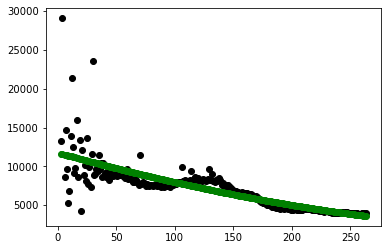

In [17]:

fig, ax = plt.subplots()
ax.scatter(reg_df.num_months,reg_df.cost_per_kW, c='black')
ax.scatter(x,y_poly_pred, c = 'g')
plt.show()

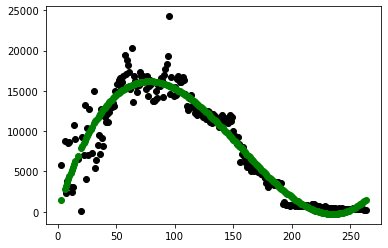

In [18]:
reg_df2 = new_df[['num_months','rebate_or_grant']].dropna()
reg_df2 = reg_df2.groupby('num_months').rebate_or_grant.mean().reset_index()

polynomial_features= PolynomialFeatures(degree=3)
x2 = reg_df2.num_months.to_numpy().reshape(-1,1)
x_poly2 = polynomial_features.fit_transform(x2)

model2 = LinearRegression()
model2.fit(x_poly2, reg_df2.rebate_or_grant)
y_poly_pred2 = model2.predict(x_poly2)

fig, ax = plt.subplots()
ax.scatter(reg_df2.num_months,reg_df2.rebate_or_grant, c='black')
ax.scatter(x2,y_poly_pred2, c = 'g')
plt.show()

In [19]:
price_map = dict(zip(reg_df.num_months,[round(y,2) for y in y_poly_pred]))
rebate_map = dict(zip(reg_df2.num_months,[round(y,2) for y in y_poly_pred2]))

In [20]:
new_df['system_size_DC'] = new_df['system_size_DC'].fillna(0)



new_df['num_months'] = new_df.install_month.apply(
    lambda d: (d.year - min_yr) * 12 + (d.month - min_mo)
)



month_dict = dict(zip(new_df.install_month, new_df.num_months))

new_df.head()

,installation_date,system_size_DC,total_installed_price,rebate_or_grant,zip_code,battery_rated_capacity_kWh,ground_mounted,third_party_owned,install_month,cost_per_kW,num_months,zip_id,i_d
965743,NaT,0.0,NaN,NaN,00501,NaN,NaN,NaN,NaT,NaN,NaN,0,0
977927,NaT,0.0,NaN,NaN,00501,NaN,NaN,NaN,NaT,NaN,NaN,0,1
990111,NaT,0.0,NaN,NaN,00501,NaN,NaN,NaN,NaT,NaN,NaN,0,2
1002295,NaT,0.0,NaN,NaN,00501,NaN,NaN,NaN,NaT,NaN,NaN,0,3
1014479,NaT,0.0,NaN,NaN,00501,NaN,NaN,NaN,NaT,NaN,NaN,0,4


In [ ]:
dmax = new_df.i_d.max()

d_d = dict(zip(np.linspace(0,dmax,dmax+1),
               pd.date_range(new_df.installation_date.min(), new_df.installation_date.max(), periods=dmax+1)))

new_df['installation_date'] = new_df.i_d.map(d_d)

In [22]:
new_df['install_month'] = new_df.installation_date.dt.strftime('%Y-%m')
new_df['install_month'] = pd.to_datetime(new_df['install_month']) + MonthEnd(1)
new_df['install_month'] = new_df.install_month.apply(lambda x: x.strftime('%Y-%m-%d'))
new_df['i_d'] = new_df.i_d.astype(float)
new_df['num_months'] = pd.to_datetime(new_df.install_month).map(month_dict)
new_df['num_months'] = new_df.num_months.astype(float)
new_df['cost_per_kW'] = new_df['cost_per_kW'].fillna(new_df['num_months'].map(price_map))
new_df['rebate_or_grant'] = new_df['rebate_or_grant'].fillna(new_df['num_months'].map(rebate_map))

In [23]:
df_filtered = new_df[['system_size_DC','cost_per_kW','rebate_or_grant','i_d','install_month','num_months','zip_code']].dropna()

df_filtered.head()

,system_size_DC,cost_per_kW,rebate_or_grant,i_d,install_month,num_months,zip_code
1708965,0.0,11644.84,1506.85,61.0,1998-04-30,3.0,00501
1721149,0.0,11644.84,1506.85,62.0,1998-04-30,3.0,00501
1733333,0.0,11644.84,1506.85,63.0,1998-04-30,3.0,00501
1745517,0.0,11644.84,1506.85,64.0,1998-04-30,3.0,00501
1757701,0.0,11644.84,1506.85,65.0,1998-04-30,3.0,00501


In [24]:
with open(cfg["data_dir"] + cfg["house_p"], 'rb') as fp:
    house_map = pickle.load(fp)

In [25]:
def h_map(x):
    im = int(x[0].split('-')[0])
    zc = int(x[1])
    try:
        return house_map[im][zc]
    except:
        return np.nan
             

df_filtered['house_ct'] = [h_map(x) for x in zip(df_filtered.install_month,df_filtered.zip_code)]
df_filtered.sample(5)

,system_size_DC,cost_per_kW,rebate_or_grant,i_d,install_month,num_months,zip_code,house_ct
73772408,0.00,5107.160000,2143.83,5993.0,2014-06-30,197.0,03249,5146.222222
11014070,0.00,10620.810000,10212.67,825.0,2000-05-31,28.0,60615,NaN
877490,3.66,4053.825137,-54.31,7446.0,2018-06-30,245.0,98368,8846.333333
81411264,0.00,4593.490000,264.41,6632.0,2016-03-31,218.0,14564,6242.666667
46880149,0.00,7187.660000,12749.78,3771.0,2008-05-31,124.0,54515,409.000000


In [26]:
df_filtered['house_ct'] = df_filtered['house_ct'].apply(lambda x: int(round(x,0)) if x==x else np.nan)
df_filtered.sample(5)

,system_size_DC,cost_per_kW,rebate_or_grant,i_d,install_month,num_months,zip_code,house_ct
6195794,0.0,11146.60,6244.58,429.0,1999-04-30,15.0,22435,NaN
6142845,0.0,11187.65,5890.48,425.0,1999-03-31,14.0,12571,4548.0
34886053,0.0,8244.04,15806.70,2785.0,2005-09-30,92.0,97701,27682.0
60151938,0.0,6104.43,7383.35,4866.0,2011-05-31,160.0,64133,NaN
33730163,0.0,8347.59,15947.46,2690.0,2005-06-30,89.0,19608,8484.0


In [27]:
conn_proj = sqlite3.connect(cfg["db_dir"] + cfg["install_db"])
cursor_proj = conn_proj.cursor()

q_1 = """DROP TABLE IF EXISTS installation;"""

cursor_proj.execute(q_1)

q_2 = """
CREATE TABLE installation (
    id   INTEGER PRIMARY KEY AUTOINCREMENT,
    size REAL,
    price REAL,
    discount REAL,
    day REAL,
    i_month TEXT,
    month REAL,
    zipcode TEXT,
    housing REAL
);"""

cursor_proj.execute(q_2)

q_3 = "INSERT INTO installation (size,price,discount,day, i_month, month, zipcode, housing) VALUES (?,?,?,?,?,?,?,?)"

conn_proj.executemany(q_3, df_filtered.to_records(index = False))
conn_proj.commit()

conn_proj.close

<function Connection.close>